# Group Project
## NAMES

In [64]:
import polars as pl
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import pyarrow
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Data Prep

In [2]:
#reading in restaurant specific data
restaurant_accepts = pl.read_csv('chefmozaccepts.csv')
restaurant_cuisine = pl.read_csv('chefmozcuisine.csv')
restaurant_hours = pl.read_csv('chefmozhours4.csv')
restaurant_parking = pl.read_csv('chefmozparking.csv')
restaurant_geo = pl.read_csv('geoplaces2.csv')

#reading in user specific data
user_cuisine = pl.read_csv('usercuisine.csv')
user_payment = pl.read_csv('userpayment.csv')
user_profile = pl.read_csv('userprofile.csv')

#reading in rating data
ratings = pl.read_csv('rating_final.csv')

In [3]:
#joining all restaurant data frames by 'placeID'
restaurant_df = (
    restaurant_geo
    .join(restaurant_accepts, on="placeID", how="left")
    .join(restaurant_cuisine, on="placeID", how="left")
    .join(restaurant_hours, on="placeID", how="left")
    .join(restaurant_parking, on="placeID", how="left")
)
print(restaurant_df)

#joining all user data frames by 'userID'
user_df = (
    user_profile
    .join(user_cuisine, on="userID", how="left")
    .join(user_payment, on="userID", how="left")
)
print(user_df)

shape: (901, 26)
┌─────────┬───────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ placeID ┆ latitude  ┆ longitude  ┆ the_geom_m ┆ … ┆ Rcuisine ┆ hours     ┆ days      ┆ parking_l │
│ ---     ┆ ---       ┆ ---        ┆ eter       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ot        │
│ i64     ┆ f64       ┆ f64        ┆ ---        ┆   ┆ str      ┆ str       ┆ str       ┆ ---       │
│         ┆           ┆            ┆ str        ┆   ┆          ┆           ┆           ┆ str       │
╞═════════╪═══════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 134999  ┆ 18.915421 ┆ -99.184871 ┆ 0101000020 ┆ … ┆ Japanese ┆ 11:00-21: ┆ Mon;Tue;W ┆ none      │
│         ┆           ┆            ┆ 957F000088 ┆   ┆          ┆ 00;       ┆ ed;Thu;Fr ┆           │
│         ┆           ┆            ┆ 568DE35671 ┆   ┆          ┆           ┆ i;        ┆           │
│         ┆           ┆            ┆ …          ┆   ┆          ┆          

In [4]:

print(restaurant_df)
print(restaurant_df.columns)

shape: (901, 26)
┌─────────┬───────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ placeID ┆ latitude  ┆ longitude  ┆ the_geom_m ┆ … ┆ Rcuisine ┆ hours     ┆ days      ┆ parking_l │
│ ---     ┆ ---       ┆ ---        ┆ eter       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ot        │
│ i64     ┆ f64       ┆ f64        ┆ ---        ┆   ┆ str      ┆ str       ┆ str       ┆ ---       │
│         ┆           ┆            ┆ str        ┆   ┆          ┆           ┆           ┆ str       │
╞═════════╪═══════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 134999  ┆ 18.915421 ┆ -99.184871 ┆ 0101000020 ┆ … ┆ Japanese ┆ 11:00-21: ┆ Mon;Tue;W ┆ none      │
│         ┆           ┆            ┆ 957F000088 ┆   ┆          ┆ 00;       ┆ ed;Thu;Fr ┆           │
│         ┆           ┆            ┆ 568DE35671 ┆   ┆          ┆           ┆ i;        ┆           │
│         ┆           ┆            ┆ …          ┆   ┆          ┆          

In [5]:
print(user_df)
print(user_df.columns)

shape: (416, 21)
┌────────┬───────────┬─────────────┬────────┬───┬────────┬────────┬────────────────┬───────────────┐
│ userID ┆ latitude  ┆ longitude   ┆ smoker ┆ … ┆ budget ┆ height ┆ Rcuisine       ┆ Upayment      │
│ ---    ┆ ---       ┆ ---         ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---            ┆ ---           │
│ str    ┆ f64       ┆ f64         ┆ str    ┆   ┆ str    ┆ f64    ┆ str            ┆ str           │
╞════════╪═══════════╪═════════════╪════════╪═══╪════════╪════════╪════════════════╪═══════════════╡
│ U1001  ┆ 22.139997 ┆ -100.978803 ┆ false  ┆ … ┆ medium ┆ 1.77   ┆ American       ┆ cash          │
│ U1002  ┆ 22.150087 ┆ -100.983325 ┆ false  ┆ … ┆ low    ┆ 1.87   ┆ Mexican        ┆ cash          │
│ U1003  ┆ 22.119847 ┆ -100.946527 ┆ false  ┆ … ┆ low    ┆ 1.69   ┆ Mexican        ┆ cash          │
│ U1004  ┆ 18.867    ┆ -99.183     ┆ false  ┆ … ┆ medium ┆ 1.53   ┆ Bakery         ┆ cash          │
│ U1004  ┆ 18.867    ┆ -99.183     ┆ false  ┆ … ┆ medium ┆ 1.53   ┆ Bakery

In [6]:
user_df.head()

userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
str,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,f64,str,str
"""U1001""",22.139997,-100.978803,"""false""","""abstemious""","""informal""","""family""","""on foot""","""single""","""independent""",1989,"""variety""","""thrifty-protector""","""none""","""student""","""black""",69,"""medium""",1.77,"""American""","""cash"""
"""U1002""",22.150087,-100.983325,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1990,"""technology""","""hunter-ostentatious""","""Catholic""","""student""","""red""",40,"""low""",1.87,"""Mexican""","""cash"""
"""U1003""",22.119847,-100.946527,"""false""","""social drinker""","""formal""","""family""","""public""","""single""","""independent""",1989,"""none""","""hard-worker""","""Catholic""","""student""","""blue""",60,"""low""",1.69,"""Mexican""","""cash"""
"""U1004""",18.867,-99.183,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1940,"""variety""","""hard-worker""","""none""","""professional""","""green""",44,"""medium""",1.53,"""Bakery""","""cash"""
"""U1004""",18.867,-99.183,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1940,"""variety""","""hard-worker""","""none""","""professional""","""green""",44,"""medium""",1.53,"""Bakery""","""bank_debit_cards"""


In [7]:
restaurant_df.head()

placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Mon;Tue;Wed;Thu;Fri;""","""none"""
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Sat;""","""none"""
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Sun;""","""none"""
132825,22.147392,-100.983092,"""0101000020957F00001AD016568C48…","""puesto de tacos""","""esquina santos degollado y leo…","""s.l.p.""","""s.l.p.""","""mexico""","""?""","""78280""","""No_Alcohol_Served""","""none""","""informal""","""completely""","""low""","""?""","""familiar""","""f""","""open""","""none""","""cash""","""Mexican""","""09:00-12:00;""","""Mon;Tue;Wed;Thu;Fri;""","""none"""
132825,22.147392,-100.983092,"""0101000020957F00001AD016568C48…","""puesto de tacos""","""esquina santos degollado y leo…","""s.l.p.""","""s.l.p.""","""mexico""","""?""","""78280""","""No_Alcohol_Served""","""none""","""informal""","""completely""","""low""","""?""","""familiar""","""f""","""open""","""none""","""cash""","""Mexican""","""09:00-12:00;""","""Sat;""","""none"""


## User Data Clustering

In [8]:
user_df = user_df.with_columns([
    pl.when(pl.col(col).cast(str).str.to_lowercase().is_in(["?", "none"]))
    .then(None)
    .otherwise(pl.col(col))
    .alias(col)
    for col in user_df.columns
])
print(len(user_df))
user_df.null_count()

416


userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3,0,6,6,8,4,13,0,38,0,53,8,0,0,7,0,0,5


In [9]:
joined_user_df = ratings.join(user_df, on="userID", how="inner")
joined_user_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,f64,str,str
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""VISA"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""cash"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""bank_debit_cards"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""VISA"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""cash"""


In [32]:
user_data = joined_user_df.drop(["Rcuisine", "Upayment", "color", "religion", "height"])
user_data.head()


userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,i64,str
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium"""


In [33]:
id_cols = user_data.select(["userID", "placeID"])
categorical_cols = [
    "smoker", "drink_level", "dress_preference", "ambience", "transport",
    "marital_status", "hijos", "interest", "personality", "activity", "budget", "rating",
    "food_rating", "service_rating"
]

# One-hot encode
user_data_dummies = user_data.to_dummies(columns=categorical_cols)
features_only = user_data_dummies.drop(["userID", "placeID"])  # drop any non-feature cols


In [34]:

df_pd = features_only.to_pandas()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pd)

In [13]:
# Calculate inertia for k from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pd)
    inertia.append(kmeans.inertia_)

# Create a DataFrame for Plotly
elbow_df = pd.DataFrame({
    "k": list(k_range),
    "inertia": inertia
})

# Create interactive elbow plot
fig = px.line(elbow_df, x="k", y="inertia", markers=True,
              title="Elbow Method for Optimal k",
              labels={"k": "Number of Clusters", "inertia": "Inertia"})

fig.update_layout(xaxis=dict(dtick=1), template="plotly_white")
fig.show()

In [35]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster labels to the original Polars DataFrame
final_user_df = user_data.with_columns(pl.Series("cluster", clusters))

In [36]:

final_user_df.head(10)

userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,cluster
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,i32
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",132825,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",132825,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",132825,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0


In [37]:
fig = px.histogram(final_user_df, x="cluster", title="User Count by Cluster Segment")
fig.show()

In [38]:
# Group by cluster and dress preference, then count
dress_data = final_user_df.select('cluster','dress_preference')
#dress_cluster_agg = dress_data.group_by(['cluster', 'dress_preference']).len()
# Convert to pandas
dress_data_pd = final_user_df.to_pandas()

# Create stacked bar chart
fig = px.histogram(
    dress_data_pd,
    x="cluster",                      # x-axis: clusters
    color="dress_preference",        # stacked segments: dress preference
    barmode="stack",                 # stack the bars
    title="Stacked Bar Chart of Dress Preference by Cluster",
    category_orders={"cluster": sorted(dress_data_pd["cluster"].unique())}
)


fig.show()

# Table showing distribution
dress_summary = (
    dress_data
    .group_by(["cluster", "dress_preference"])
    .agg(pl.count())
    .pivot(
        values="count",
        index="cluster",
        columns="dress_preference"
        )
    .fill_null(0)  # Optional: fill in missing values with 0
)

print(dress_summary)

shape: (3, 6)
┌─────────┬────────┬───────────────┬──────────┬─────────┬──────┐
│ cluster ┆ formal ┆ no preference ┆ informal ┆ elegant ┆ null │
│ ---     ┆ ---    ┆ ---           ┆ ---      ┆ ---     ┆ ---  │
│ i32     ┆ u32    ┆ u32           ┆ u32      ┆ u32     ┆ u32  │
╞═════════╪════════╪═══════════════╪══════════╪═════════╪══════╡
│ 2       ┆ 398    ┆ 40            ┆ 667      ┆ 9       ┆ 0    │
│ 0       ┆ 213    ┆ 682           ┆ 549      ┆ 69      ┆ 62   │
│ 1       ┆ 8      ┆ 0             ┆ 1447     ┆ 0       ┆ 0    │
└─────────┴────────┴───────────────┴──────────┴─────────┴──────┘


/var/folders/8x/9q78ljcd4v5_8_sj7ft_y7g00000gq/T/ipykernel_53904/3305994439.py:24: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

/var/folders/8x/9q78ljcd4v5_8_sj7ft_y7g00000gq/T/ipykernel_53904/3305994439.py:22: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



In [39]:
fig = px.histogram(final_user_df, x='dress_preference', text_auto=True)
fig.update_layout(yaxis_title='Count')
fig.show()

In [40]:
segment_summary = final_user_df.group_by('cluster').agg([
    pl.mean('latitude').alias('mean_latitude'),
    pl.mean('longitude').alias('mean_longitude'),
    pl.mean('birth_year').alias('mean_birth_year'),
    pl.mean('weight').alias('mean_weight'),
    pl.len().alias('n_users')
])

segment_summary



cluster,mean_latitude,mean_longitude,mean_birth_year,mean_weight,n_users
i32,f64,f64,f64,f64,u32
0,21.422055,-100.409068,1979.871746,60.565079,1575
1,22.170335,-100.950199,1988.023368,65.997938,1455
2,22.284009,-100.727253,1986.410233,72.395871,1114


In [41]:
# List of categorical columns
categorical_columns = ["smoker", "drink_level", "dress_preference", "ambience", "transport",
    "marital_status", "hijos", "interest", "personality", "activity", "budget", "rating",
    "food_rating", "service_rating"]

# Initialize list to store distributions
category_distribution = []

# For each categorical column, compute the distribution of values by cluster
for col in categorical_columns:
    distribution = final_user_df.group_by('cluster').agg(
        [
            pl.col(col).filter(pl.col(col).is_not_null()).count().alias(f'{col}_count')
        ]
    )
    category_distribution.append(distribution)


category_distribution

[shape: (3, 2)
 ┌─────────┬──────────────┐
 │ cluster ┆ smoker_count │
 │ ---     ┆ ---          │
 │ i32     ┆ u32          │
 ╞═════════╪══════════════╡
 │ 0       ┆ 1544         │
 │ 1       ┆ 1455         │
 │ 2       ┆ 1114         │
 └─────────┴──────────────┘,
 shape: (3, 2)
 ┌─────────┬───────────────────┐
 │ cluster ┆ drink_level_count │
 │ ---     ┆ ---               │
 │ i32     ┆ u32               │
 ╞═════════╪═══════════════════╡
 │ 0       ┆ 1575              │
 │ 1       ┆ 1455              │
 │ 2       ┆ 1114              │
 └─────────┴───────────────────┘,
 shape: (3, 2)
 ┌─────────┬────────────────────────┐
 │ cluster ┆ dress_preference_count │
 │ ---     ┆ ---                    │
 │ i32     ┆ u32                    │
 ╞═════════╪════════════════════════╡
 │ 0       ┆ 1513                   │
 │ 1       ┆ 1455                   │
 │ 2       ┆ 1114                   │
 └─────────┴────────────────────────┘,
 shape: (3, 2)
 ┌─────────┬────────────────┐
 │ cluster ┆ amb

## Resturants Clustering

In [21]:
restaurant_df = restaurant_df.with_columns([
    pl.when(pl.col(col).cast(str).str.to_lowercase().is_in(["?", "none"]))
    .then(None)
    .otherwise(pl.col(col))
    .alias(col)
    for col in restaurant_df.columns
])
print(len(restaurant_df))
restaurant_df.null_count()

901


placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,138,93,90,156,901,417,0,429,0,0,0,780,0,0,0,802,51,213,16,16,340


In [22]:
joined_rest_df = ratings.join(restaurant_df, on="placeID", how="inner")
joined_rest_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Mon;Tue;Wed;Thu;Fri;""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Sat;""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Sun;""","""public"""
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""",null,"""08:00-17:00;""","""Mon;Tue;Wed;Thu;Fri;""",null
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""",null,"""08:00-17:00;""","""Sat;""",null


In [31]:
restaurant_data = joined_rest_df.drop(["fax", "zip", "url", "Rpayment","days", "area", "hours", "other_services", "Rpayment"])
restaurant_data.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,city,state,country,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,Rcuisine,parking_lot
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null


In [24]:
id_cols = restaurant_data.select(["placeID"])
categorical_rest_cols = [
    "the_geom_meter","name", "address", "city", "state", "country",
    "alcohol", "smoking_area", "dress_code", "accessibility", "price", "Rambience",
    "franchise", "Rcuisine", "parking_lot", "rating",
    "food_rating", "service_rating", "the_geom_meter"
]

# One-hot encode
restaurant_data_dummies = restaurant_data.to_dummies(columns=categorical_rest_cols)
features_only = restaurant_data_dummies.drop(["placeID"])


In [25]:
rest_df_pd = restaurant_data_dummies.to_pandas()

# Scale the data
scaler = StandardScaler()
rest_df_scaled = scaler.fit_transform(rest_df_pd)

In [26]:
# Calculate inertia for k from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rest_df_scaled)
    inertia.append(kmeans.inertia_)

# Create a DataFrame for Plotly
elbow_df = pd.DataFrame({
    "k": list(k_range),
    "inertia": inertia
})

# Create interactive elbow plot
fig = px.line(elbow_df, x="k", y="inertia", markers=True,
              title="Elbow Method for Optimal k",
              labels={"k": "Number of Clusters", "inertia": "Inertia"})

fig.update_layout(xaxis=dict(dtick=1), template="plotly_white")
fig.show()

In [42]:
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(rest_df_scaled)

# Add cluster labels to the original Polars DataFrame
final_rest_df = restaurant_data.with_columns(pl.Series("cluster", clusters))


In [43]:
fig = px.histogram(final_rest_df, x="cluster", title="Restaurant Count by Cluster Segment")
fig.show()

In [44]:
rest_segment_summary = final_rest_df.group_by('cluster').agg([
    pl.mean('latitude').alias('mean_latitude'),
    pl.mean('longitude').alias('mean_longitude'),
    pl.len().alias('n_users')
])

rest_segment_summary

cluster,mean_latitude,mean_longitude,n_users
i32,f64,f64,u32
1,22.147175,-100.974269,72
4,22.174887,-100.970825,96
7,22.160381,-100.988045,108
3,22.142273,-100.942654,15
0,22.154687,-100.996617,153
2,21.902911,-100.726793,6874
8,22.173595,-100.994603,72
5,22.455318,-100.501315,894
6,22.144337,-100.937382,18


In [45]:
final_user_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,cluster
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,i32
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0


In [46]:
final_rest_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,city,state,country,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,Rcuisine,parking_lot,cluster
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",2
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",2
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",2
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null,2
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null,2


In [47]:
final_user_df = final_user_df.rename({"cluster": "user_cluster"})
final_rest_df = final_rest_df.rename({"cluster": "restaurant_cluster"})

# Join on userID and placeID to link ratings with both cluster labels
user_rest_cluster_df = final_user_df.join(
    final_rest_df.select(["userID", "placeID", "restaurant_cluster"]),
    on=["userID", "placeID"],
    how="inner"
)

In [48]:
user_rest_cluster_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,user_cluster,restaurant_cluster
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,i32,i32
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0,2
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0,2
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0,2
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0,2
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",0,2


In [49]:
interaction_summary = user_rest_cluster_df.group_by(["user_cluster", "restaurant_cluster"]).agg([
    pl.len().alias("n_ratings"),
    pl.mean("rating").alias("avg_rating"),
    pl.mean("food_rating").alias("avg_food_rating"),
    pl.mean("service_rating").alias("avg_service_rating")
])

# Optional: sort it for better readability
interaction_summary = interaction_summary.sort(["user_cluster", "restaurant_cluster"])

# Show summary
print(interaction_summary)


shape: (20, 6)
┌──────────────┬────────────────────┬───────────┬────────────┬─────────────────┬───────────────────┐
│ user_cluster ┆ restaurant_cluster ┆ n_ratings ┆ avg_rating ┆ avg_food_rating ┆ avg_service_ratin │
│ ---          ┆ ---                ┆ ---       ┆ ---        ┆ ---             ┆ g                 │
│ i32          ┆ i32                ┆ u32       ┆ f64        ┆ f64             ┆ ---               │
│              ┆                    ┆           ┆            ┆                 ┆ f64               │
╞══════════════╪════════════════════╪═══════════╪════════════╪═════════════════╪═══════════════════╡
│ 0            ┆ 0                  ┆ 171       ┆ 0.631579   ┆ 0.789474        ┆ 0.631579          │
│ 0            ┆ 1                  ┆ 306       ┆ 1.058824   ┆ 1.117647        ┆ 1.0               │
│ 0            ┆ 2                  ┆ 10397     ┆ 1.491103   ┆ 1.449745        ┆ 1.37732           │
│ 0            ┆ 3                  ┆ 15        ┆ 1.2        ┆ 1.2          

## Classification

In [53]:
# Summarize ratings between user and restaurant clusters
cluster_rating_summary = user_rest_cluster_df.group_by(["user_cluster", "restaurant_cluster"]).agg([
    pl.mean("rating").alias("avg_rating"),
    pl.len().alias("n_ratings")
])
# For each user cluster, get the restaurant cluster with the highest avg_rating
preferred_cluster = (
    cluster_rating_summary.sort("avg_rating", descending=True)
    .group_by("user_cluster")
    .agg(pl.first("restaurant_cluster").alias("preferred_restaurant_cluster"))
)

preferred_cluster

user_cluster,preferred_restaurant_cluster
i32,i32
1,5
0,7
2,1


In [54]:
user_features = final_user_df.drop(["placeID", "rating", "food_rating", "service_rating"])
labeled_user_data = user_features.join(preferred_cluster, on="user_cluster", how="inner")


In [ ]:
# Drop non-feature columns (IDs and target)
user_features = labeled_user_data.drop(["userID", "user_cluster", "preferred_restaurant_cluster"])

# Identify categorical columns (you can customize this list if needed)
categorical_cols = [
    "smoker", "drink_level", "dress_preference", "ambience", "transport",
    "marital_status", "hijos", "interest", "personality", "activity", "budget"
]

# One-hot encode
user_features_encoded = user_features.to_dummies(columns=categorical_cols)

X = user_features_encoded.to_pandas()

# Get the target labels
y = labeled_user_data.select("preferred_restaurant_cluster").to_pandas()["preferred_restaurant_cluster"]


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.96      0.95       230
           5       1.00      0.99      1.00       280
           7       0.97      0.96      0.97       319

    accuracy                           0.97       829
   macro avg       0.97      0.97      0.97       829
weighted avg       0.97      0.97      0.97       829



In [62]:
probas = clf.predict_proba(X_test)

# top-K cluster indices
top_k = 3
top_k_indices = np.argsort(probas, axis=1)[:, -top_k:][:, ::-1]

# class labels (restaurant cluster IDs)
cluster_labels = clf.classes_

# map indices back to labels
top_k_labels = np.array(cluster_labels)[top_k_indices]
top_k_df = pd.DataFrame(top_k_labels, columns=[f"Top_{i+1}" for i in range(top_k)])
top_k_df.head()

,Top_1,Top_2,Top_3
0,5,7,1
1,7,5,1
2,7,5,1
3,1,7,5
4,7,5,1


In [65]:
y_pred = clf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

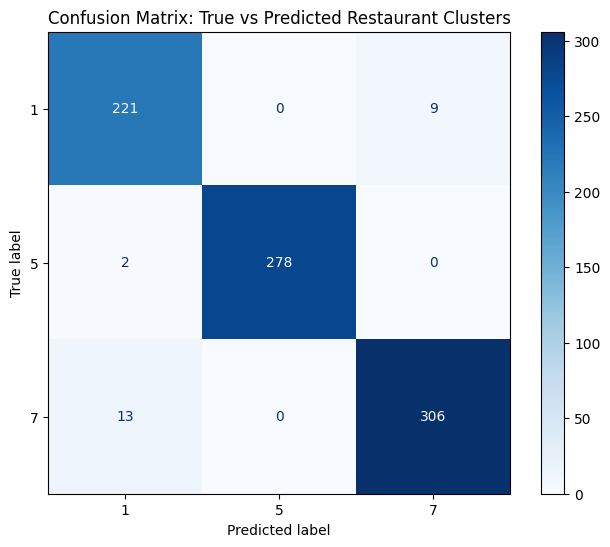

In [66]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: True vs Predicted Restaurant Clusters")
plt.show()

## Other visualizations

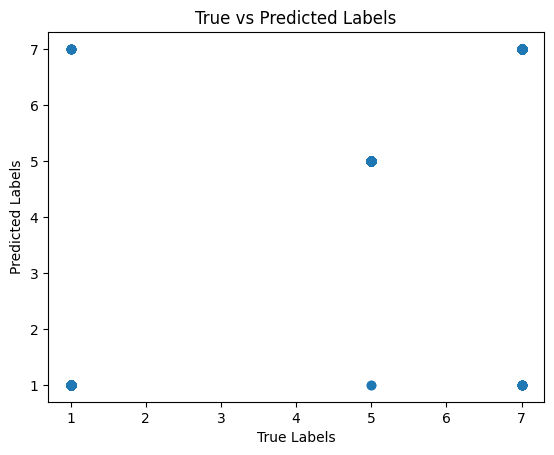

In [67]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Labels')
plt.show()

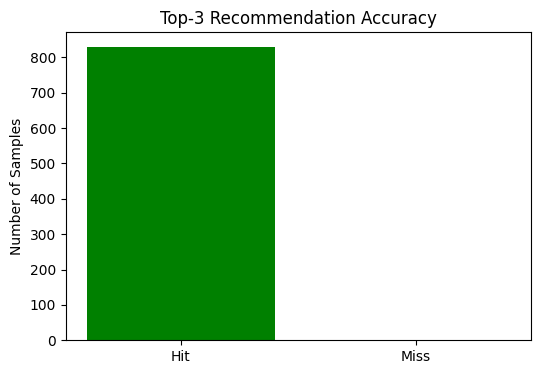

In [68]:
top_k_hit = [true in pred_row for true, pred_row in zip(y_test.values, top_k_labels)]
plt.figure(figsize=(6, 4))
plt.bar(["Hit", "Miss"], [sum(top_k_hit), len(top_k_hit) - sum(top_k_hit)], color=["green", "red"])
plt.title(f"Top-{top_k} Recommendation Accuracy")
plt.ylabel("Number of Samples")
plt.show()